In [1]:
%matplotlib inline

 # local package
from email_extractor import get_emails_df
from email_nlp import clean_message

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud
from PIL import Image

In [2]:
SPAM_1_PATH = 'spam-data/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'spam-data/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'spam-data/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'spam-data/spam_assassin_corpus/easy_ham_2'

SPAM_CATEGORY = 1
HAM_CATEGORY = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = '~/Área de Trabalho/emails_data.json' # MY desktop path
WORD_ID_FILE = 'spam-data/word-by-id.csv'

THUMBS_UP_IMG_PATH = 'img/thumbs-up-solid.png'
THUMBS_DOWN_IMG_PATH = 'img/thumbs-down-solid.png'

ROBOTO_FONT_PATH = 'fonts/Roboto-Light.ttf'

# *Gather data:*
### *load spam and ham body email DataFrames*

In [3]:
spam_emails = get_emails_df(SPAM_1_PATH, SPAM_CATEGORY)
spam_emails = spam_emails.append(get_emails_df(SPAM_2_PATH, SPAM_CATEGORY))

print(spam_emails.shape)
spam_emails.head()

(1898, 2)


,MESSAGE,CATEGORY
00279.1d58a13e343c1e53aca2ed2121a3f815,"5, Meridian East\n\nLeicester LE3 2WZ \n\nLeic...",1
00380.a262abe251ca7cc3026e4e146d9cf817,"<html>\n\n<TABLE id=AutoNumber2 style=""BORDER-...",1
00176.79f82496c612ea28f45f13ca5c47f8c2,<html>\n\n<head>\n\n<title></title>\n\n</head>...,1
00461.1a27d007492d1c665d07db820b7dc3b8,<html>\n\n<head>\n\n<title>Tell Me Where to Se...,1
00300.834f370a21ca4f1774d5724b5443411c,"<HTML>\n\n<BODY>\n\n<meta http-equiv=""Content-...",1


In [4]:
ham_emails = get_emails_df(EASY_NONSPAM_1_PATH, HAM_CATEGORY)
ham_emails = ham_emails.append(get_emails_df(EASY_NONSPAM_2_PATH, HAM_CATEGORY))

print(ham_emails.shape)
ham_emails.head()

(3901, 2)


,MESSAGE,CATEGORY
02152.8df514c41920019281f8f0723dad0001,URL: http://www.aaronsw.com/weblog/000622\n\nD...,0
01482.a3576ddec34b0481a9a671c1f3c141c3,"Tony L. Svanstrom wrote:\n\n\n\n>On Sun, 15 Se...",0
00152.703c271de3d42fb8bf266db6f77a0dda,"Thanks for the info AJ, I found ""weblog"" at \n...",0
00699.29e599983f044aee500f3a58c34acffc,"Gary Lawrence Murphy wrote:\n\n\n\n>>>>>>""R"" =...",0
01846.af884c94693e5cce571396b4fd151167,URL: http://boingboing.net/#85481660\n\nDate: ...,0


#### *full-data (spam/nonspam)*

In [5]:
data = pd.concat([spam_emails, ham_emails])
data.shape

(5799, 2)

# *Data cleaning*

In [6]:
# checking for null values
data.MESSAGE.isnull().values.any() # "Returns False unless there is at least one element within a series or along a Dataframe axis that is True or equivalent"
# data.MESSAGE.isnull().sum()

False

In [7]:
# checking for empty emails
print((data.MESSAGE.str.len() == 0).any())
# checking how many empty emails in the dataset
print((data.MESSAGE.str.len() == 0).sum())

True
3


In [8]:
# locate empty emails and remove empty emails
print(data[(data.MESSAGE.str.len() == 0)].index)
data.drop(['cmds'], inplace=True)

Index(['cmds', 'cmds', 'cmds'], dtype='object')


In [9]:
# re-check if drop was successful.
print((data.MESSAGE.str.len() == 0).any())

False


#### *Add IDs to emails for better dataset manipulation*

In [10]:
print(len(data.index))
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids # add new column

data

5796


,MESSAGE,CATEGORY,DOC_ID
00279.1d58a13e343c1e53aca2ed2121a3f815,"5, Meridian East\n\nLeicester LE3 2WZ \n\nLeic...",1,0
00380.a262abe251ca7cc3026e4e146d9cf817,"<html>\n\n<TABLE id=AutoNumber2 style=""BORDER-...",1,1
00176.79f82496c612ea28f45f13ca5c47f8c2,<html>\n\n<head>\n\n<title></title>\n\n</head>...,1,2
00461.1a27d007492d1c665d07db820b7dc3b8,<html>\n\n<head>\n\n<title>Tell Me Where to Se...,1,3
00300.834f370a21ca4f1774d5724b5443411c,"<HTML>\n\n<BODY>\n\n<meta http-equiv=""Content-...",1,4
...,...,...,...
01264.df4dfa46001904d832d56d2eabd4894d,"On Fri, Aug 16, 2002 at 07:58:07PM +0200, Tors...",0,5791
01298.c00e52eb757de239c8863a7a01ea0544,Update of /cvsroot/spamassassin/spamassassin\n...,0,5792
00908.fa150b0b994587469112fbcb7e8cc2bc,"On Fri, 2002-07-26 at 11:50, Ian Andrew Bell w...",0,5793
00077.7a4f2e80b3a2e2c1cc2442f54a9e01ee,"On Fri, Jul 19, 2002 at 10:00:02PM +0100, Matt...",0,5794


In [11]:
# rearrange columns
data['FILE_NAME'] = data.index # add new column with file_names
data.set_index('DOC_ID', inplace=True) # set the index as DOC_ID

In [12]:
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"5, Meridian East\n\nLeicester LE3 2WZ \n\nLeic...",1,00279.1d58a13e343c1e53aca2ed2121a3f815
1,"<html>\n\n<TABLE id=AutoNumber2 style=""BORDER-...",1,00380.a262abe251ca7cc3026e4e146d9cf817
2,<html>\n\n<head>\n\n<title></title>\n\n</head>...,1,00176.79f82496c612ea28f45f13ca5c47f8c2
3,<html>\n\n<head>\n\n<title>Tell Me Where to Se...,1,00461.1a27d007492d1c665d07db820b7dc3b8
4,"<HTML>\n\n<BODY>\n\n<meta http-equiv=""Content-...",1,00300.834f370a21ca4f1774d5724b5443411c
...,...,...,...
5791,"On Fri, Aug 16, 2002 at 07:58:07PM +0200, Tors...",0,01264.df4dfa46001904d832d56d2eabd4894d
5792,Update of /cvsroot/spamassassin/spamassassin\n...,0,01298.c00e52eb757de239c8863a7a01ea0544
5793,"On Fri, 2002-07-26 at 11:50, Ian Andrew Bell w...",0,00908.fa150b0b994587469112fbcb7e8cc2bc


#### *Export cleaned data as JSON file*

In [13]:
data.to_json(DATA_JSON_FILE) # exported to desktop for now

---

# *Data Visualization*

In [14]:
data.CATEGORY.value_counts()
amount_ham, amount_spam = data.CATEGORY.value_counts()
print(amount_ham, amount_spam)

3900 1896


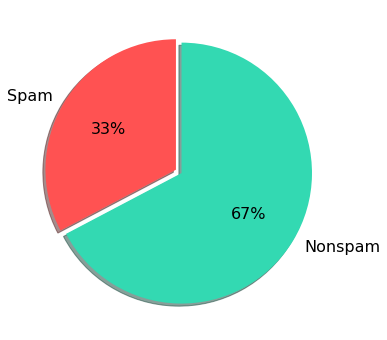

In [15]:
# Generate pie chart
category_names = ['Spam', 'Nonspam']
sizes = [amount_spam, amount_ham]
pie_colors = ['#ff5252', '#33d9b2']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=category_names, 
        textprops={'fontsize': 16}, startangle=90, 
        autopct='%1.0f%%', colors=pie_colors,
        explode=[0, 0.05], shadow=True         
       )
plt.show()

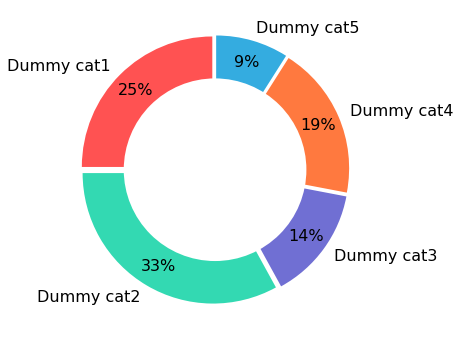

In [16]:
# Generate donut chart 
# more useful when dealing with a higher number of categories
# Leaving it here for reference only
category_names = ['Dummy cat1', 'Dummy cat2', 'Dummy cat3', 'Dummy cat4', 'Dummy cat5']
sizes = [25, 33, 14, 19, 9] # dummy values
pie_colors = ['#ff5252', '#33d9b2', '#706fd3', '#ff793f', '#34ace0']
offset = [0.03, 0.03, 0.03, 0.03, 0.03]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=category_names, 
        textprops={'fontsize': 16}, startangle=90, 
        autopct='%1.0f%%', colors=pie_colors,
        explode=offset, pctdistance=0.83)
# draw a circle inside
center_circle = plt.Circle((0,0), radius=0.7, fc='white') # fc must match the background color
plt.gca().add_artist(center_circle)
plt.show()

---

# *NLP preprocessing*
### Cleaning and tokenizing emails

#### *Apply clean_message to first 5 emails (test)*

In [17]:
nested_lists = data.MESSAGE.iloc[0:5].apply(clean_message)
nested_lists

DOC_ID
0    [meridian, east, leicest, leicest, citi, unit,...
1    [never, pay, retail, unleash, pc, multimedia, ...
2    [mother, natur, natur, marit, aid, men, women,...
3    [tell, send, health, card, request, receiv, ma...
4    [fortun, liter, made, great, new, marketplac, ...
Name: MESSAGE, dtype: object

In [18]:
# obs: syntax looks confusing, is there a better way?
# https://www.w3schools.com/python/python_lists_comprehension.asp
flat_list = [token for sublist in nested_lists for token in sublist]
print('First items:\n', flat_list[0:20], '\n', 'Number of tokens:\n', len(flat_list))

First items:
 ['meridian', 'east', 'leicest', 'leicest', 'citi', 'unit', 'kingdom', 'date', 'capt', 'john', 'okel', 'dear', 'sir', 'got', 'contact', 'militari', 'friend', 'train', 'countri', 'captain'] 
 Number of tokens:
 494


---
#### Apply to the whole dataset

In [19]:
# apply to the whole dataset
print('Number of emails:', len(data.MESSAGE))

Number of emails: 5796


In [20]:
%%time

full_nested_lists = data.MESSAGE.apply(clean_message)
# CPU times: user 49.2 s, sys: 77.5 ms, total: 49.3 s
# Wall time: 49.4 s

/home/edlcorrea/miniconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 49.7 s, sys: 157 ms, total: 49.9 s
Wall time: 50 s


In [21]:
full_nested_lists.head()

DOC_ID
0    [meridian, east, leicest, leicest, citi, unit,...
1    [never, pay, retail, unleash, pc, multimedia, ...
2    [mother, natur, natur, marit, aid, men, women,...
3    [tell, send, health, card, request, receiv, ma...
4    [fortun, liter, made, great, new, marketplac, ...
Name: MESSAGE, dtype: object

In [22]:
full_nested_lists.tail()

DOC_ID
5791    [fri, aug, torsten, bronger, wrote, creat, rpm...
5792    [updat, directori, modifi, file, manifest, log...
5793    [fri, ian, andrew, bell, wrote, rule, class, w...
5794    [fri, jul, matthew, french, wrote, thought, un...
5795    [craig, problem, miss, hash, address, write, f...
Name: MESSAGE, dtype: object

In [23]:
%%time
full_flat_list = [token for sublist in full_nested_lists for token in sublist] 

CPU times: user 27.8 ms, sys: 0 ns, total: 27.8 ms
Wall time: 27.5 ms


In [24]:
len(full_flat_list)

759560

---
### *Separate tokens lists by category*

In [25]:
# store ids for different categories
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [26]:
%%time
# generate separated token lists for spam and nonspam
ham_nested_lists = data.MESSAGE.loc[doc_ids_ham].apply(clean_message)
spam_nested_lists = data.MESSAGE.loc[doc_ids_spam].apply(clean_message)

ham_flat_list = [token for sublist in ham_nested_lists for token in sublist]
spam_flat_list = [token for sublist in spam_nested_lists for token in sublist]

# CPU times: user 51 s, sys: 367 ms, total: 51.4 s
# Wall time: 51.5 s

/home/edlcorrea/miniconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 49.8 s, sys: 135 ms, total: 49.9 s
Wall time: 50 s


In [27]:
print(ham_flat_list[0:20], '...' )
print(spam_flat_list[0:20], '...')

['url', 'http', 'date', 'aaron', 'warchalk', 'probabl', 'public', 'radio', 'marketplac', 'tomorrow', 'even', 'tri', 'cut', 'number', 'know', 'well', 'keep', 'tri', 'toni', 'svanstrom'] ...
['meridian', 'east', 'leicest', 'leicest', 'citi', 'unit', 'kingdom', 'date', 'capt', 'john', 'okel', 'dear', 'sir', 'got', 'contact', 'militari', 'friend', 'train', 'countri', 'captain'] ...


In [28]:
normal_words = pd.Series(ham_flat_list)
print('Number of normal words:', normal_words.shape[0])
spammy_words = pd.Series(spam_flat_list)
print('Number of spammy words:', spammy_words.shape[0])

Number of normal words: 442061
Number of spammy words: 317499


---
## Spam x Ham viz with Word Clouds

In [29]:
# store ham and spam words as strings (required to generate wordcloud)
ham_as_str = ' '.join(ham_flat_list)
spam_as_str = ' '.join(spam_flat_list)

In [30]:
%%time
# define the format of the wordcloud
thumbs_up = Image.open(THUMBS_UP_IMG_PATH)
img_mask = Image.new(mode='RGB', size=thumbs_up.size, color=(255, 255, 255))
img_mask.paste(thumbs_up, box=thumbs_up)
ham_mask = np.array(img_mask)
# generate ham word cloud
ham_wordcloud = WordCloud(font_path=ROBOTO_FONT_PATH, mask=ham_mask, 
                          background_color='black', max_words=2000,
                          colormap='Greens', max_font_size=300, min_font_size=2)
ham_wordcloud.generate(ham_as_str.upper())

CPU times: user 5.66 s, sys: 200 ms, total: 5.86 s
Wall time: 5.88 s


In [31]:
%%time
# define the format
thumbs_down = Image.open(THUMBS_DOWN_IMG_PATH)
img_mask = Image.new(mode='RGB', size=thumbs_down.size, color=(255, 255 ,255))
img_mask.paste(thumbs_down, box=thumbs_down)
spam_mask = np.array(img_mask)

# generate spam word cloud
spam_wordcloud = WordCloud(font_path=ROBOTO_FONT_PATH, mask=spam_mask, 
                           background_color='black', max_words=2000,
                           colormap='Reds', max_font_size=300, min_font_size=2)
spam_wordcloud.generate(spam_as_str.upper())

CPU times: user 4.77 s, sys: 172 ms, total: 4.94 s
Wall time: 4.97 s


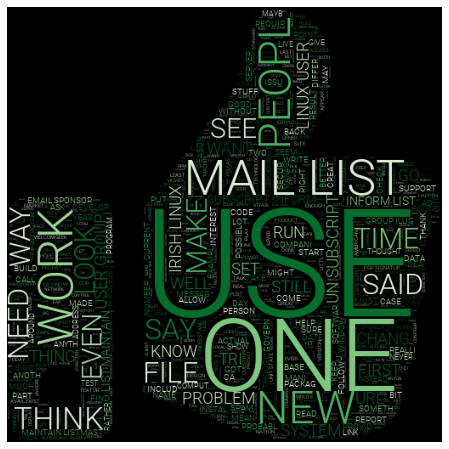

In [32]:
# display ham wordcloud
plt.figure(figsize=[16, 8])
plt.imshow(ham_wordcloud)
plt.axis('off')
plt.show()

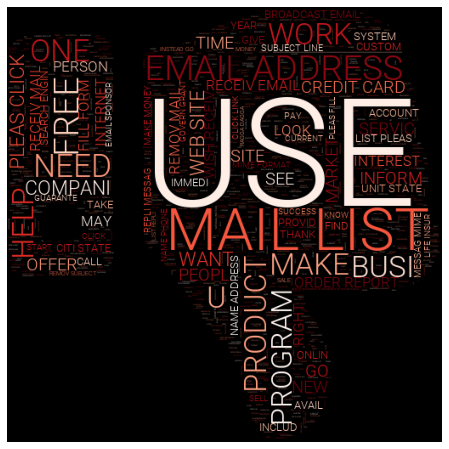

In [33]:
# display spam wordcloud
plt.figure(figsize=[16, 8])
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.show()

##### *Note about the words: The words used in the wordcloud are stemmed. To use full words, the clean_message function should be edited to also return non-stemmed words. I will keep it like that for simplicity.*

---

# *Create vocabulary and dictionary*

In [34]:
unique_words = pd.Series(full_flat_list).value_counts()
print('Number of unique words: ', unique_words.shape[0])
# subset the 2500 most frequent words
frequent_words = unique_words[:VOCAB_SIZE]

Number of unique words:  27334


In [35]:
# format frequent_words into a DataFrame with IDS
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_IDS'

vocab

,VOCAB_WORD
WORD_IDS,
0,http
1,use
2,list
3,email
4,get
...,...
2495,ximian
2496,manner
2497,cpu


### *Export vocab as CSV*

In [36]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

---